In [2]:

import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('C:/Users/Arvin/Desktop/nlp_trial/SEED_IV'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


C:/Users/Arvin/Desktop/nlp_trial/SEED_IV\Channel Order.xlsx
C:/Users/Arvin/Desktop/nlp_trial/SEED_IV\ReadMe.txt
C:/Users/Arvin/Desktop/nlp_trial/SEED_IV\SEED-IV_stimulation.xlsx
C:/Users/Arvin/Desktop/nlp_trial/SEED_IV\eeg_feature_smooth\1\10_20151014.mat
C:/Users/Arvin/Desktop/nlp_trial/SEED_IV\eeg_feature_smooth\1\11_20150916.mat
C:/Users/Arvin/Desktop/nlp_trial/SEED_IV\eeg_feature_smooth\1\12_20150725.mat
C:/Users/Arvin/Desktop/nlp_trial/SEED_IV\eeg_feature_smooth\1\13_20151115.mat
C:/Users/Arvin/Desktop/nlp_trial/SEED_IV\eeg_feature_smooth\1\14_20151205.mat
C:/Users/Arvin/Desktop/nlp_trial/SEED_IV\eeg_feature_smooth\1\15_20150508.mat
C:/Users/Arvin/Desktop/nlp_trial/SEED_IV\eeg_feature_smooth\1\1_20160518.mat
C:/Users/Arvin/Desktop/nlp_trial/SEED_IV\eeg_feature_smooth\1\2_20150915.mat
C:/Users/Arvin/Desktop/nlp_trial/SEED_IV\eeg_feature_smooth\1\3_20150919.mat
C:/Users/Arvin/Desktop/nlp_trial/SEED_IV\eeg_feature_smooth\1\4_20151111.mat
C:/Users/Arvin/Desktop/nlp_trial/SEED_IV\eeg_f

In [3]:
import random
import numpy as np
import torch
from torcheeg.datasets import SEEDIVFeatureDataset
from  torcheeg import  transforms
from torcheeg.datasets.constants import SEED_IV_CHANNEL_LOCATION_DICT, SEED_IV_ADJACENCY_MATRIX
from torch import nn
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn import svm
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pickle
from time import time
from torcheeg.models import FBCNet, GRU, FBCCNN, EEGNet, DGCNN, ViT , LSTM , SSTEmotionNet
import torch.nn as nn
import scipy.stats as stats
from scipy.signal import hann
from torcheeg.models import BCGenerator, BCDiscriminator





C:\Users\Arvin\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# class CNN(torch.nn.Module):
#     def __init__(self, in_channels=20, num_classes=4):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.ZeroPad2d((1, 2, 1, 2)),
#             nn.Conv2d(in_channels, 64, kernel_size=4, stride=1),
#             nn.ReLU()
#         )
#         self.conv2 = nn.Sequential(
#             nn.ZeroPad2d((1, 2, 1, 2)),
#             nn.Conv2d(64, 128, kernel_size=4, stride=1),
#             nn.ReLU()
#         )
#         self.conv3 = nn.Sequential(
#             nn.ZeroPad2d((1, 2, 1, 2)),
#             nn.Conv2d(128, 256, kernel_size=4, stride=1),
#             nn.ReLU()
#         )
#         self.conv4 = nn.Sequential(
#             nn.ZeroPad2d((1, 2, 1, 2)),
#             nn.Conv2d(256, 64, kernel_size=4, stride=1),
#             nn.ReLU()
#         )

#         self.lin1 = nn.Linear(9 * 9 * 64, 1024)
#         self.lin2 = nn.Linear(1024, num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)

#         x = x.flatten(start_dim=1)
#         x = self.lin1(x)
#         x = self.lin2(x)
#         return x
    

In [55]:
def set_random_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader.dataset)
    total_loss = 0.0
    model.train()
    for batch_idx, batch in enumerate(dataloader):
        X = batch[0].to(device)
        y = batch[1].to(device)
    
        # Compute prediction error
        pred = model(X)
        
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / num_batches
        
def valid(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    correct /= size
    return correct, val_loss


def valid_with_report(dataloader, model, loss_fn, model_name, idx):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    all_predictions = []
    all_targets = []
    output_path = './output_edit'
    with torch.no_grad():
        for batch in dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            all_predictions.extend(pred.argmax(1).cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    val_loss /= num_batches
    correct /= size
    
    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f')
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    plt.savefig('{}/normalized_confusion_matrix_{}_{}.png'.format(output_path, model_name, idx))
    
    # Calculate classification report
    classification_report_str = classification_report(all_targets, all_predictions)
    
    # Print classification report
    print("{} {} Classification Report:\n".format(model_name, idx))
    print(classification_report_str)
    
    

root_path = ("C:/Users/Arvin/Desktop/nlp_trial/SEED_IV/eeg_feature_smooth")
# torch.Size([n, 62, 5])
def import_data1():
    dataset = SEEDIVFeatureDataset(root_path,
                    feature=['de_movingAve', 'de_LDS', 'psd_movingAve', 'psd_LDS'],
                    online_transform=transforms.Compose([transforms.ToTensor()]),
                    label_transform=transforms.Select('emotion'),
                        num_worker=4, 
                    io_size = 167772160)
    return dataset

#torch.Size([n, 5, 9, 9])
def import_data3():
    dataset = SEEDIVFeatureDataset(
                    root_path,
                    feature=['de_movingAve', 'de_LDS', 'psd_movingAve', 'psd_LDS'],
                    online_transform=transforms.Compose([transforms.ToGrid(SEED_IV_CHANNEL_LOCATION_DICT),
                                                        transforms.ToTensor()]),
                    label_transform=transforms.Compose([
                        transforms.Select('emotion'),
                        transforms.Lambda(lambda x: x)
                    ]),
                        num_worker=4, 
                    io_size = 167772160)
    return dataset

def import_data4():
    dataset = SEEDIVFeatureDataset(
                    root_path,
                    feature=['de_movingAve', 'de_LDS', 'psd_movingAve', 'psd_LDS'],
                    online_transform=transforms.Compose([transforms.pyg.ToG(SEED_IV_ADJACENCY_MATRIX)]),
                    label_transform=transforms.Compose([
                        transforms.Select('emotion'),
                        transforms.Lambda(lambda x: x)
                    ]),
                        num_worker=4, 
                    io_size = 167772160)

    return dataset

def get_dataloaders(dataset, batch_size):
    num_training = int(len(dataset) * 0.8)
    num_val = int(len(dataset) * 0.1)
    num_test = len(dataset) - num_val - num_training

    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [num_training, num_val, num_test], generator=generator)

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, val_loader, test_loader

In [64]:
import torch
import torch.nn as nn
import torch_geometric.nn as gnn
import torch.nn.functional as F
from torch.nn import Module
device = torch.device('cpu')
print(device)

class EnhancedDGCNN(nn.Module):
    def __init__(self, in_channels, num_electrodes, hid_channels, num_layers, num_classes):
        super(EnhancedDGCNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(in_channels, hid_channels, kernel_size=(1, 1), stride=1))
        self.layers.append(nn.BatchNorm2d(hid_channels))
        self.layers.append(nn.ReLU(inplace=True))

        for _ in range(1, num_layers):
            self.layers.append(nn.Conv2d(hid_channels, hid_channels, kernel_size=(1, 1), stride=1))
            self.layers.append(nn.BatchNorm2d(hid_channels))
            self.layers.append(nn.ReLU(inplace=True))
            self.layers.append(nn.Dropout(0.5))

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(hid_channels, hid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(hid_channels, num_classes)
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F


class GraphConvolution(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, bias: bool=False):

        super(GraphConvolution, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.weight = nn.Parameter(torch.FloatTensor(in_channels, out_channels))
        nn.init.xavier_normal_(self.weight)
        self.bias = None
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_channels))
            nn.init.zeros_(self.bias)

    def forward(self, x: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        out = torch.matmul(adj, x)
        out = torch.matmul(out, self.weight)
        if self.bias is not None:
            return out + self.bias
        else:
            return out


class Linear(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, bias: bool=True):
        super(Linear, self).__init__()
        self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        nn.init.xavier_normal_(self.linear.weight)
        if bias:
            nn.init.zeros_(self.linear.bias)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.linear(inputs)


def normalize_A(A: torch.Tensor, symmetry: bool=False) -> torch.Tensor:
    A = F.relu(A)
    if symmetry:
        A = A + torch.transpose(A, 0, 1)
        d = torch.sum(A, 1)
        d = 1 / torch.sqrt(d + 1e-10)
        D = torch.diag_embed(d)
        L = torch.matmul(torch.matmul(D, A), D)
    else:
        d = torch.sum(A, 1)
        d = 1 / torch.sqrt(d + 1e-10)
        D = torch.diag_embed(d)
        L = torch.matmul(torch.matmul(D, A), D)
    return L


def generate_cheby_adj(A: torch.Tensor, num_layers: int) -> torch.Tensor:
    support = []
    for i in range(num_layers):
        if i == 0:
            support.append(torch.eye(A.shape[1]).to(A.device))
        elif i == 1:
            support.append(A)
        else:
            temp = torch.matmul(support[-1], A)
            support.append(temp)
    return support


class Chebynet(nn.Module):
    def __init__(self, in_channels: int, num_layers: int, out_channels: int):
        super(Chebynet, self).__init__()
        self.num_layers = num_layers
        self.gc1 = nn.ModuleList()
        for i in range(num_layers):
            self.gc1.append(GraphConvolution(in_channels, out_channels))

    def forward(self, x: torch.Tensor, L: torch.Tensor) -> torch.Tensor:
        adj = generate_cheby_adj(L, self.num_layers)
        for i in range(len(self.gc1)):
            if i == 0:
                result = self.gc1[i](x, adj[i])
            else:
                result = result+  self.gc1[i](x, adj[i])
        result = F.relu(result)
        return result


class DGCNN(nn.Module):
    r'''
    Dynamical Graph Convolutional Neural Networks (DGCNN). For more details, please refer to the following information.

    - Paper: Song T, Zheng W, Song P, et al. EEG emotion recognition using dynamical graph convolutional neural networks[J]. IEEE Transactions on Affective Computing, 2018, 11(3): 532-541.
    - URL: https://ieeexplore.ieee.org/abstract/document/8320798
    - Related Project: https://github.com/xueyunlong12589/DGCNN

    Below is a recommended suite for use in emotion recognition tasks:

    .. code-block:: python

        from torcheeg.models import DGCNN
        from torcheeg.datasets import SEEDDataset
        from torcheeg import transforms

        dataset = SEEDDataset(root_path='./Preprocessed_EEG',
                              offline_transform=transforms.BandDifferentialEntropy(band_dict={
                                  "delta": [1, 4],
                                  "theta": [4, 8],
                                  "alpha": [8, 14],
                                  "beta": [14, 31],
                                  "gamma": [31, 49]
                              }),
                              online_transform=transforms.Compose([
                                  transforms.ToTensor()
                              ]),
                              label_transform=transforms.Compose([
                                  transforms.Select('emotion'),
                                  transforms.Lambda(lambda x: x + 1)
                              ]))

        model = DGCNN(in_channels=5, num_electrodes=62, hid_channels=32, num_layers=2, num_classes=2)

        x, y = next(iter(DataLoader(dataset, batch_size=64)))
        model(x)

    Args:
        in_channels (int): The feature dimension of each electrode. (default: :obj:`5`)
        num_electrodes (int): The number of electrodes. (default: :obj:`62`)
        num_layers (int): The number of graph convolutional layers. (default: :obj:`2`)
        hid_channels (int): The number of hidden nodes in the first fully connected layer. (default: :obj:`32`)
        num_classes (int): The number of classes to predict. (default: :obj:`2`)
    '''
    def __init__(self,
                 in_channels: int = 5,
                 num_electrodes: int = 62,
                 num_layers: int = 2,
                 hid_channels: int = 32,
                 num_classes: int = 2):
        super(DGCNN, self).__init__()
        self.in_channels = in_channels
        self.num_electrodes = num_electrodes
        self.hid_channels = hid_channels
        self.num_layers = num_layers
        self.num_classes = num_classes

        self.layer1 = Chebynet(in_channels, num_layers, hid_channels)
        self.BN1 = nn.BatchNorm1d(in_channels)
        self.fc1 = Linear(num_electrodes * hid_channels, 64)
        self.fc2 = Linear(64, num_classes)
        self.A = nn.Parameter(torch.FloatTensor(num_electrodes, num_electrodes))
        nn.init.xavier_normal_(self.A)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        r'''
        Args:
            x (torch.Tensor): EEG signal representation, the ideal input shape is :obj:`[n, 62, 5]`. Here, :obj:`n` corresponds to the batch size, :obj:`62` corresponds to :obj:`num_electrodes`, and :obj:`5` corresponds to :obj:`in_channels`.

        Returns:
            torch.Tensor[number of sample, number of classes]: the predicted probability that the samples belong to the classes.
        '''
        x = self.BN1(x.transpose(1, 2)).transpose(1, 2)
        L = normalize_A(self.A)
        result = self.layer1(x, L)
        result = result.reshape(x.shape[0], -1)
        result = F.relu(self.fc1(result))
        result = self.fc2(result)
        return result



cpu


In [7]:
import numpy as np
np.random.seed(0)
sample_eeg_data = np.random.randn(14, 62, 33601)

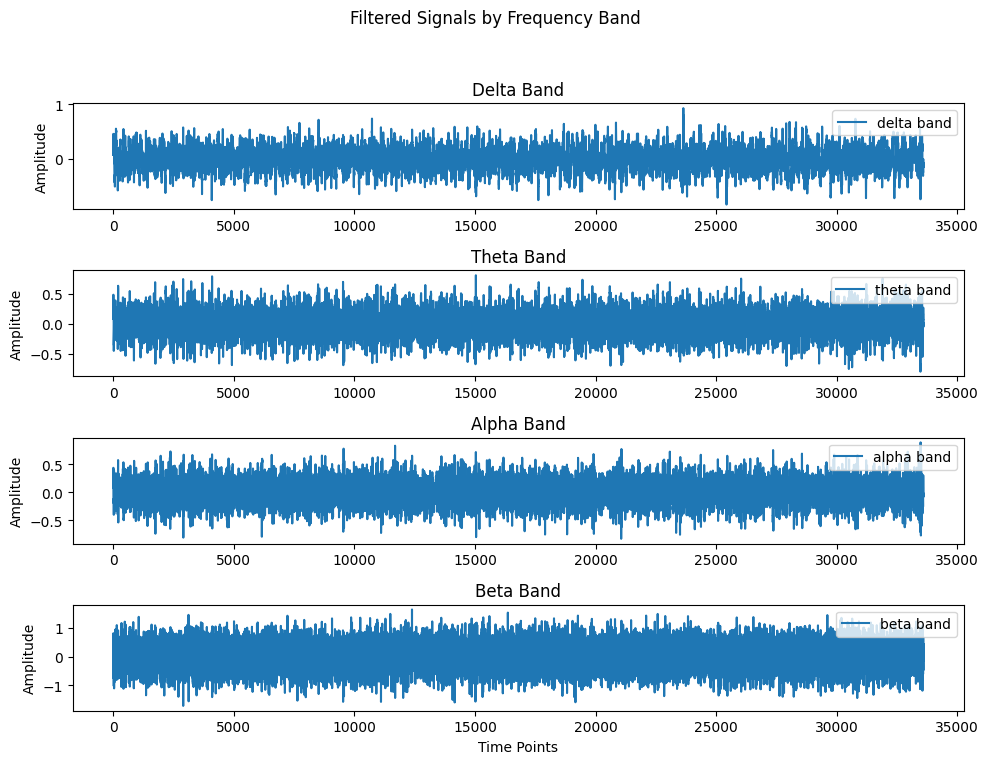

In [8]:
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

class BandSignal:
    def __init__(self):
        # Define frequency bands
        self.bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30)}
        self.fs = 256  # Sampling frequency

    def bandpass_filter(self, data, lowcut, highcut):
        nyq = 0.5 * self.fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(1, [low, high], btype='band')
        return lfilter(b, a, data)

    def __call__(self, signal):
        # Assume signal shape is (channels, time_points)
        filtered_signals = {band: self.bandpass_filter(signal, *freqs) for band, freqs in self.bands.items()}
        self.plot_signals(filtered_signals)
        return filtered_signals

    def plot_signals(self, filtered_signals):
        fig, axs = plt.subplots(len(filtered_signals), 1, figsize=(10, 8))
        fig.suptitle('Filtered Signals by Frequency Band')
        
        for i, (band, signal) in enumerate(filtered_signals.items()):
            axs[i].plot(signal[0], label=f'{band} band')  # Plotting the first channel as an example
            axs[i].set_title(f'{band.capitalize()} Band')
            axs[i].set_ylabel('Amplitude')
            axs[i].legend(loc='upper right')
        
        axs[-1].set_xlabel('Time Points')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Assuming you have EEG data loaded in `sample_eeg_data`
band_signal_transform = BandSignal()
band_signals = band_signal_transform(sample_eeg_data[0])  # Apply to the first sample for demonstration


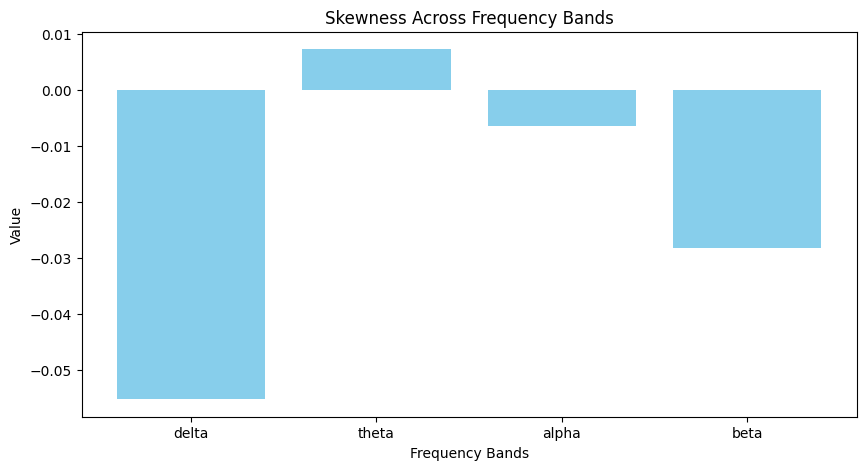

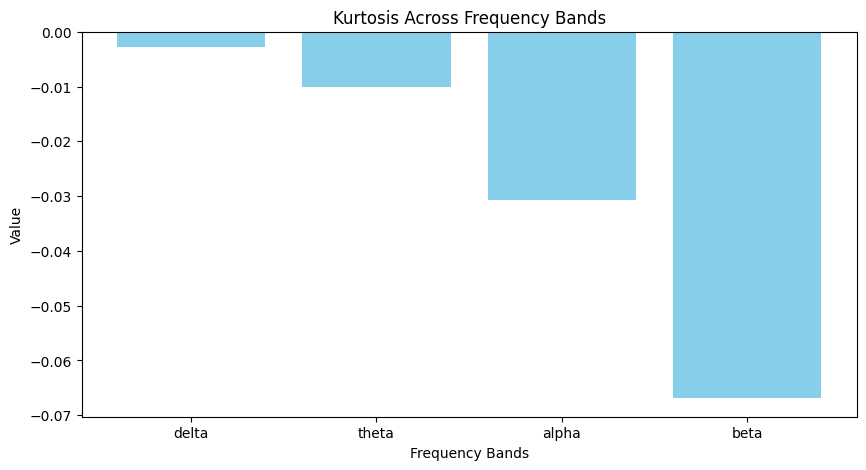

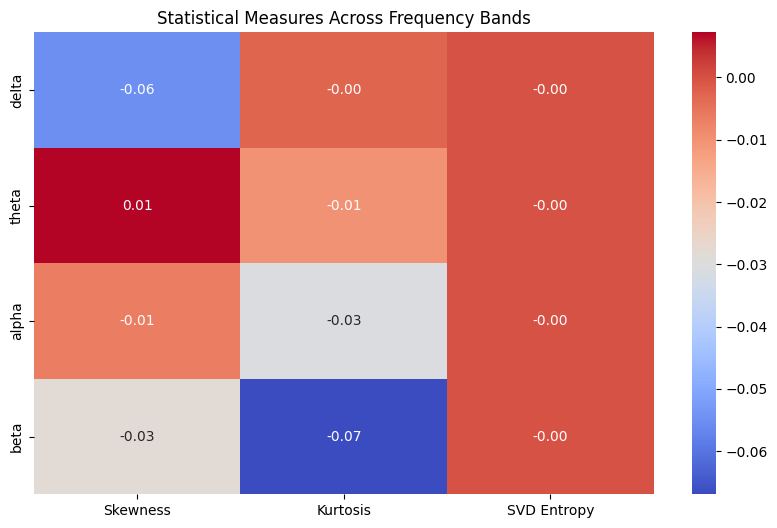

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import butter, lfilter, freqz
import scipy.stats as stats

class BandSignal:
    def __init__(self):
        self.bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30)}
        self.fs = 256  # Sampling frequency

    def bandpass_filter(self, data, lowcut, highcut):
        nyq = 0.5 * self.fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(1, [low, high], btype='band')
        return lfilter(b, a, data)

    def __call__(self, signal):
        return {band: self.bandpass_filter(signal, *freqs) for band, freqs in self.bands.items()}

class BandSkewness:
    def __call__(self, signals):
        return {band: stats.skew(signal, axis=-1) for band, signal in signals.items()}

class BandKurtosis:
    def __call__(self, signals):
        return {band: stats.kurtosis(signal, axis=-1) for band, signal in signals.items()}

class BandSVDEntropy:
    def __call__(self, signals):
        return {band: self.calculate_svd_entropy(signal) for band, signal in signals.items()}

    def calculate_svd_entropy(self, signal):
        if signal.ndim == 1:  # Check if the signal is one-dimensional
            signal = signal.reshape(1, -1)  # Reshape to make it two-dimensional (1 x length)
        u, s, vh = np.linalg.svd(signal, full_matrices=False)
        norm_vals = s**2 / np.sum(s**2)
        entropy = -np.sum(norm_vals * np.log(norm_vals))
        return entropy


# Assuming 'sample_eeg_data' is defined and contains EEG data
# Here's a demonstration of how you might load and apply these transformations
sample_eeg_data = np.random.randn(1, 2560)  # Simulated random EEG data (1 channel, 10 seconds at 256 Hz)

band_signal_transform = BandSignal()
band_signals = band_signal_transform(sample_eeg_data[0])  # Applying to the first sample

band_skewness_transform = BandSkewness()
band_skewness = band_skewness_transform(band_signals)

band_kurtosis_transform = BandKurtosis()
band_kurtosis = band_kurtosis_transform(band_signals)

band_svd_entropy_transform = BandSVDEntropy()
band_svd_entropy = band_svd_entropy_transform(band_signals)

# Plotting function for Skewness and Kurtosis
def plot_statistics(statistics, title):
    bands = list(statistics.keys())
    values = [statistics[band] for band in bands]
    
    plt.figure(figsize=(10, 5))
    plt.bar(bands, values, color='skyblue')
    plt.xlabel('Frequency Bands')
    plt.ylabel('Value')
    plt.title(title)
    plt.show()

plot_statistics(band_skewness, 'Skewness Across Frequency Bands')
plot_statistics(band_kurtosis, 'Kurtosis Across Frequency Bands')

# Heatmap for all measures
data = {
    'Skewness': band_skewness,
    'Kurtosis': band_kurtosis,
    'SVD Entropy': band_svd_entropy
}
df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Statistical Measures Across Frequency Bands')
plt.show()


In [10]:
import_data1()[0][0].shape 

[2024-08-31 12:51:14] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to .torcheeg\datasets_1725088874802_Z0YmE.
[2024-08-31 12:51:14] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[PROCESS]: 100%|██████████| 45/45 [00:58<00:00,  1.31s/it]
[2024-08-31 12:52:24] INFO (torcheeg/MainThread) ✅ | All processed EEG data has been cached to .torcheeg\datasets_1725088874802_Z0YmE.
[2024-08-31 12:52:24] INFO (torcheeg/MainThread) 😊 | Please set io_path to .torcheeg\datasets_1725088874802_Z0YmE for the next run, to directly read from the cache if you wish to skip the data processing step.


torch.Size([62, 20])

In [11]:
def train_fun(seed, model, model_name, epochs = 100):
    set_random_seed(seed)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    best_val_loss = float("inf")
    final_test_acc = 0.0
    best_epoch = 0
    train_loss_list = []
    train_acc_list = []
    val_acc_list = []
    train_times = []
    for t in range(epochs):
        s_time = time()
        train_loss = train(train_loader, model, loss_fn, optimizer)
        train_times.append(time() - s_time)
        train_acc, _ = valid(train_loader, model, loss_fn)
        val_acc, val_loss = valid(val_loader, model, loss_fn)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        if best_val_loss > val_loss:
            best_val_loss = val_loss
            test_acc, _ = valid(test_loader, model, loss_fn)
            final_test_acc = test_acc
        if (t + 1) % print_every == 0:
            log_format = (
                "Epoch {}: loss={:.4f}, train_acc={:.4f}, val_acc={:.4f}, final_test_acc={:.4f}"
            )
            print(log_format.format(t + 1, train_loss, train_acc, val_acc, final_test_acc))
    print(
        "Best Epoch {}, final test acc {:.4f}".format(
            best_epoch, final_test_acc
        )
    )
    print("Done!")
    
    torch.save(model.state_dict(), './output_edit/last_{}_weights_trail{}.pth'.format(model_name, seed))
    valid_with_report(test_loader, model, loss_fn, model_name, seed)
    
    return final_test_acc, sum(train_times) / len(train_times), [train_loss_list, train_acc_list, val_acc_list] 

In [12]:
def mean_of_n_values(arr, smoth):
    arr = arr.reshape(arr.shape[0], -1, smoth)
    mean = arr.mean(axis=2)
    return mean.reshape(mean.shape[0], -1)

def boxplot(accs, output_path, name, model_type):
    # Plot the distribution of average degree for each type of graph
    fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
    ax.set_title('Test Accurcy of diffrente trail models')
    ax.boxplot(accs)
    ax.set_xticklabels([model_type])
    plt.show()
    plt.savefig('{}/boxplot_{}_{}.png'.format(output_path, name, model_type))

def acc_loss_plot(results, epochs, smoth, num_trials, output_path, feat_type):
    results = np.array(results)

    # generate sample data
    plt.figure(figsize=(14, 10), dpi=80)

    x = np.arange(0,epochs,smoth)

    loss_train_results = mean_of_n_values(results[:, 0, :], smoth)
    acc_train_results = mean_of_n_values(results[:, 1, :], smoth)
    acc_valid_results = mean_of_n_values(results[:, 2, :], smoth)
        
    plt.plot(x, np.mean(acc_train_results,axis=0), label='Train Accurcy')
    plt.fill_between(x, np.min(acc_train_results,axis=0), np.max(acc_train_results,axis=0), alpha=0.2, label='Train Accurcy Noise')
    plt.plot(x, np.mean(acc_valid_results,axis=0), label='Valid Accurcy')
    plt.fill_between(x, np.min(acc_valid_results,axis=0), np.max(acc_valid_results,axis=0), alpha=0.2, label='Valid Accurcy Noise')
    plt.title("train plot and valid plot over {:4d} models ploted the mean with min noise and max noise smothed every {:4d} epochs".format(num_trials, smoth))
    plt.legend()
    plt.savefig('{}/accurcy_plot_valid_train_{}.png'.format(output_path, feat_type))

        
    plt.figure(figsize=(14, 10), dpi=80)

    x = np.arange(0,epochs,smoth)

    plt.plot(x, np.mean(loss_train_results,axis=0), label='Train Loss')
    plt.fill_between(x, np.min(loss_train_results,axis=0), np.max(loss_train_results,axis=0), alpha=0.2, label='Train Loss Noise')

    plt.title(" loss plot over over {:4d} models ploted the mean with min noise and max noise smothed every {:4d} epochs".format(num_trials, smoth))
    plt.legend()
    plt.show()
    plt.savefig('{}/loss_plot_train_{}.png'.format(output_path, feat_type))    

def stats(model_name, num_trials):
    boxplot(accs, './output_edit', "Test_Accurcy", model_name)
    acc_loss_plot(stat_list, epochs, 1, num_trials, './output_edit', model_name)
    

def get_stats(array, conf_interval=False, name=None, stdout=False, logout=False):

    eps = 1e-9
    array = torch.Tensor(array)
    std, mean = torch.std_mean(array)
    std = std.item()
    mean = mean.item()
    center = mean

    if conf_interval:
        n = array.size(0)
        se = std / (math.sqrt(n) + eps)
        t_value = t.ppf(0.975, df=n - 1)
        err_bound = t_value * se
    else:
        err_bound = std

    return center, err_bound




In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print (device)
loss_fn = nn.CrossEntropyLoss()
batch_size = 128
print_every = 5
epochs = 50
num_trials =1

cpu


In [71]:

def import_model_and_data(idx):
    if idx == 0:
        model = DGCNN(in_channels=20, 
                    num_electrodes=62, 
                    hid_channels=32, 
                    num_layers=2, 
                    num_classes=4).to(device)
        data = import_data1()

    elif idx == 1:
        # Complex DGCNN model
        model = DGCNN()
        data = import_data1()  
    
    return model, data

models_names = ['DGCNN','GraphConvolution','DGCNN']


A subdirectory or file output_edit already exists.
[2024-08-31 16:58:54] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to .torcheeg\datasets_1725103734455_0UAqF.
[2024-08-31 16:58:54] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.


Trial 1/1


[PROCESS]: 100%|██████████| 45/45 [01:03<00:00,  1.42s/it]
[2024-08-31 17:00:09] INFO (torcheeg/MainThread) ✅ | All processed EEG data has been cached to .torcheeg\datasets_1725103734455_0UAqF.
[2024-08-31 17:00:09] INFO (torcheeg/MainThread) 😊 | Please set io_path to .torcheeg\datasets_1725103734455_0UAqF for the next run, to directly read from the cache if you wish to skip the data processing step.


Epoch 5: loss=0.0071, train_acc=0.6975, val_acc=0.6896, final_test_acc=0.6900
Epoch 10: loss=0.0051, train_acc=0.8028, val_acc=0.7911, final_test_acc=0.7871
Epoch 15: loss=0.0039, train_acc=0.8625, val_acc=0.8544, final_test_acc=0.8483
Epoch 20: loss=0.0031, train_acc=0.8974, val_acc=0.8927, final_test_acc=0.8877
Epoch 25: loss=0.0025, train_acc=0.9248, val_acc=0.9207, final_test_acc=0.9093
Epoch 30: loss=0.0020, train_acc=0.9435, val_acc=0.9417, final_test_acc=0.9279
Epoch 35: loss=0.0017, train_acc=0.9560, val_acc=0.9518, final_test_acc=0.9436
Epoch 40: loss=0.0014, train_acc=0.9656, val_acc=0.9625, final_test_acc=0.9529
Epoch 45: loss=0.0011, train_acc=0.9736, val_acc=0.9694, final_test_acc=0.9619
Epoch 50: loss=0.0009, train_acc=0.9799, val_acc=0.9760, final_test_acc=0.9699
Best Epoch 0, final test acc 0.9699
Done!


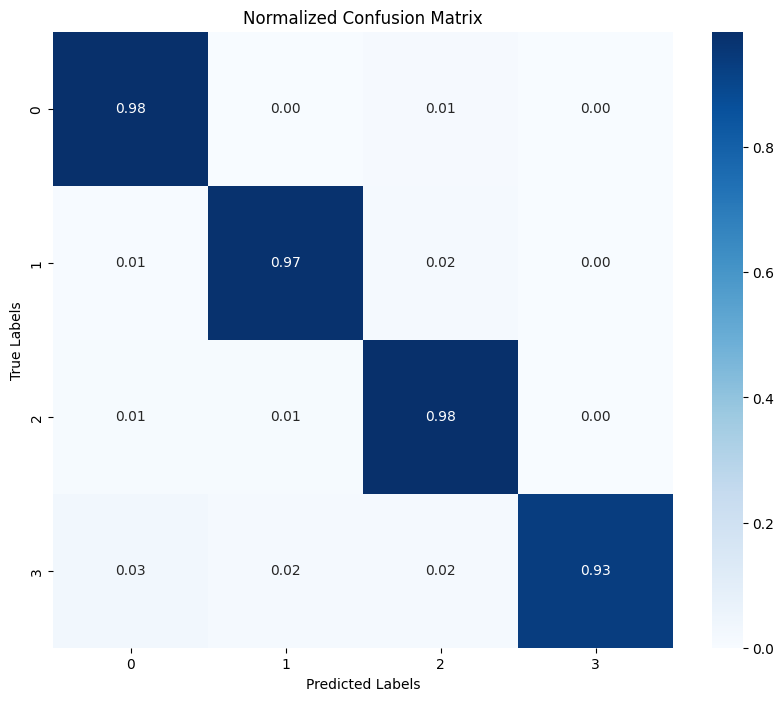

DGCNN 0 Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1029
           1       0.98      0.97      0.98      1032
           2       0.95      0.98      0.97       900
           3       0.99      0.93      0.96       797

    accuracy                           0.97      3758
   macro avg       0.97      0.97      0.97      3758
weighted avg       0.97      0.97      0.97      3758



<Figure size 640x480 with 0 Axes>

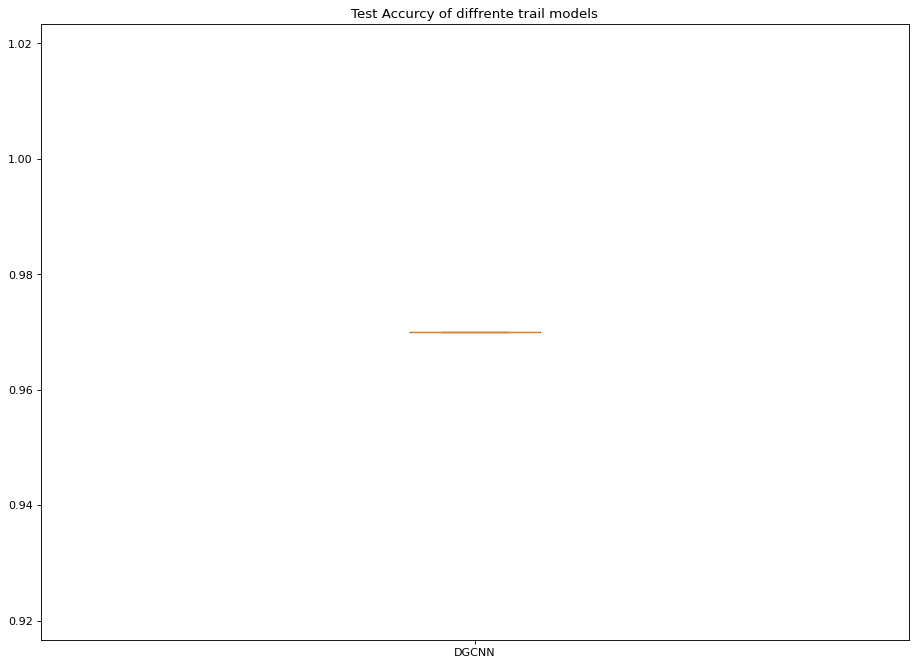

<Figure size 640x480 with 0 Axes>

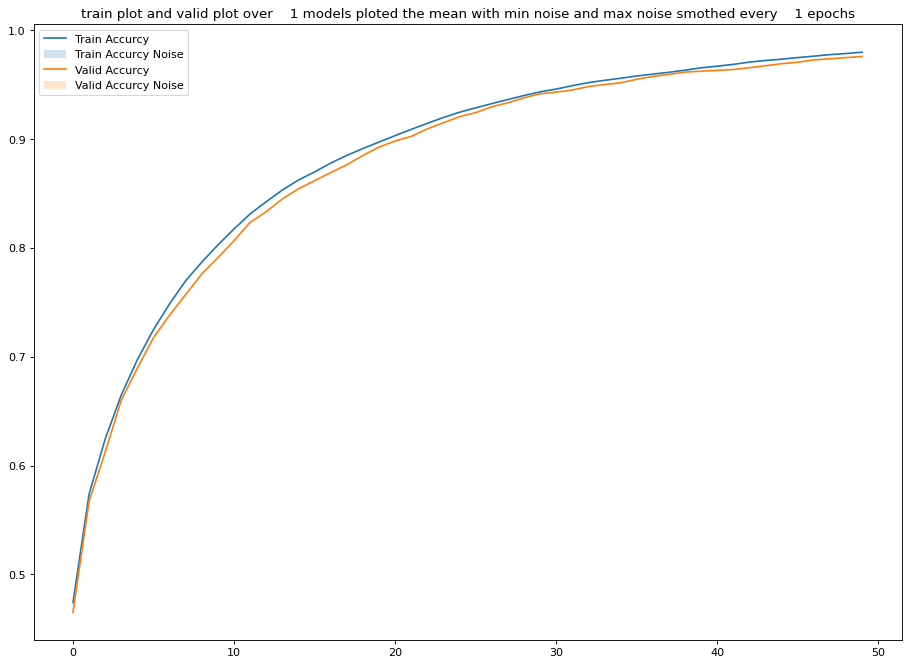

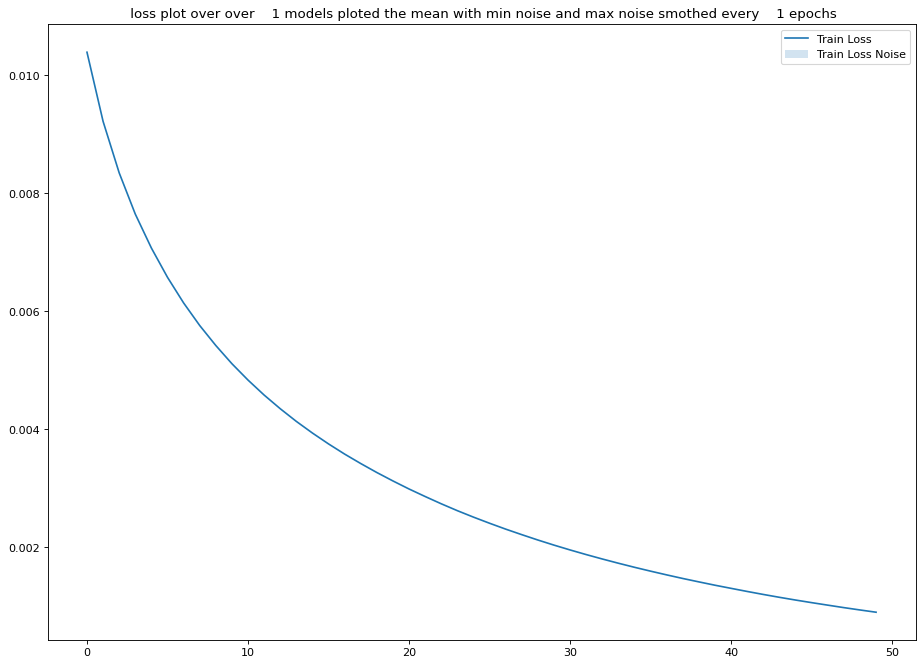

DGCNN mean acc: 0.9699, error bound: nan, time taken 3.0201s


C:\Users\Arvin\AppData\Local\Temp\ipykernel_20872\1210879569.py:57: UserWarning: std_mean(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  std, mean = torch.std_mean(array)


<Figure size 640x480 with 0 Axes>

In [72]:
!mkdir output_edit

import torch
import pickle

list_accs = []
list_stat_list = []
list_last_accs = []
models_times = []
for idxx in [0]:

    accs = []
    idx = None
    best_acc = -1
    stat_list = []
    model_name = models_names[idxx]
    time_takenn = 0
    for i in range(num_trials):
        print("Trial {}/{}".format(i + 1, num_trials))
        set_random_seed(i)
        model, dataset = import_model_and_data(idxx)
        train_loader, val_loader, test_loader = get_dataloaders(dataset, batch_size)
        acc, time_taken, stat = train_fun(i, model, model_name, epochs)
        accs.append(acc)
        if best_acc < acc:
            idx = i
            best_acc = acc
            # Save the model when a new best accuracy is found
            #torch.save(model.state_dict(), f'output_edit/{model_name}_best_trial_{i}.pt')

        stat_list.append(stat)
        time_takenn += time_taken
        
    list_last_accs.append(best_acc)
    list_stat_list.append(stat_list)
    list_accs.append(accs)
    models_times.append(time_takenn/num_trials)
    stats(model_name, num_trials)

    mean, err_bd = get_stats(accs)
    print(model_name + " mean acc: {:.4f}, error bound: {:.4f}, time taken {:.4f}s".format(mean, err_bd, time_takenn/num_trials))
    
# Save the list to a file
# with open('list_last_accs.pkl', 'wb') as file:
#     pickle.dump(list_last_accs, file)
    
# with open('list_stat_list.pkl', 'wb') as file:
#     pickle.dump(list_stat_list, file)
    
# with open('list_accs.pkl', 'wb') as file:
#     pickle.dump(list_accs, file)

# with open('models_times.pkl', 'wb') as file:
#     pickle.dump(models_times, file)


In [73]:
import scipy.io as sio
import torch
import numpy as np
import torch.nn as nn

class GraphCNN(nn.Module):
    def __init__(self, in_channels=20, num_classes=4):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(64, 128, kernel_size=4, stride=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(128, 256, kernel_size=4, stride=1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(256, 64, kernel_size=4, stride=1),
            nn.ReLU()
        )
        # Temporary input to simulate passing through all layers to find output size
        temp_x = torch.rand(1, in_channels, 1, 320)  # Example size, adjust height accordingly
        temp_x = self.conv4(self.conv3(self.conv2(self.conv1(temp_x))))
        self.flattened_size = temp_x.data.view(1, -1).size(1)
        self.lin1 = nn.Linear(self.flattened_size, 1024)
        self.lin2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.lin1(x)
        x = self.lin2(x)
        return x

# Load the .mat file
mat_file_path = "C:/Users/Arvin/Desktop/nlp_trial/SEED_IV/eeg_feature_smooth/1/1_20160518.mat"
mat_data = sio.loadmat(mat_file_path, simplify_cells=True)

# Select the feature and instance to use (e.g., 'de_LDS15')
feature_instance = 'de_LDS15'
feature_data = mat_data[feature_instance]

# Flatten the last two dimensions and take the first 20 'channels'
feature_data = feature_data.reshape(62, -1)  # Flatten 64 and 5
feature_data = feature_data[:20, :]  # Select first 20 channels
feature_data = feature_data.reshape(1, 20, 1, -1)  # Reshape to [batch, channels, height, width]

# Convert to tensor
feature_tensor = torch.tensor(feature_data, dtype=torch.float32)

# Initialize and load your model
model = GraphCNN()
model.load_state_dict(torch.load('output_edit\DGCNN_best_trial_0.pt'), strict=False)
model.eval()

# Predict the emotion
with torch.no_grad():
    prediction = model(feature_tensor)

# Decode prediction to emotion
predicted_emotion = torch.argmax(prediction, dim=1)
print('Predicted Emotion:', predicted_emotion.item())


Predicted Emotion: 3
